In [1]:
import pdb # needs conda install
import os # base python
import pickle # base python
import json # base python
import pandas as pd # needs conda install
import numpy as np # needs conda install
from scipy.stats import ttest_rel,ttest_ind, ttest_1samp # needs conda install
import scipy
from matplotlib import pyplot as plt # needs conda install
import seaborn as sns # needs conda install
import math # base python
from sklearn.metrics import adjusted_rand_score # needs conda install

sns.set_context('talk')
%matplotlib inline
plt.rcParams['font.size'] = 22


from humanUtils import * # no conda needed
from cswHumanDatabase import load_final_df, load_dfs # no conda needed
from analysis import * # no conda needed
from utils import * # no conda needed

condL = ['blocked','interleaved','early','middle','late']
%load_ext autoreload
%autoreload 2

# human dataframe

## load and save dataframes from each experiemnt

In [2]:
## load and save
recompute = False
dfD = {}
for cond in ALL_CONDITIONS:
  for thresh in [0.9,0]:
    print(cond)
    fname = f"{cond}_thresh{int(thresh*100)}.csv"
    if recompute:
      df = load_final_df(cond,threshold=thresh) 
      df.to_csv(f'data_csv/human/{fname}')
    df = pd.read_csv(f'data_csv/human/{fname}')
    dfD[cond,thresh] = df

human_df = pd.concat(dfD,names=['condition','thresh'])

blocked
blocked
interleaved
interleaved
blocked_rep
blocked_rep
interleaved_rep
interleaved_rep
explicit_interleaved
explicit_interleaved
inserted_early
inserted_early
inserted_middle
inserted_middle
inserted_late
inserted_late
inserted_early_rep
inserted_early_rep
inserted_middle_rep
inserted_middle_rep
inserted_late_rep
inserted_late_rep


## additional formating to human df

In [3]:
# additional columns
human_df.loc[:,'score'] = human_df.correct_response
human_df.loc[:,'response_node'] = human_df.apply(lambda r: [r.false_tonode,r.true_tonode][r.correct_response],axis=1)
node2stateD = {
  "BEGIN":0,
  "LOCNODEB":1,
  "LOCNODEC":2,
  "NODE11":3,
  "NODE12":4,
  "NODE21":5,
  "NODE22":6,
  "NODE31":7,
  "NODE32":8,
  "END":9
}
human_df.loc[:,'rfc_int'] = (human_df.true_rfc.str.split('-').str[-1].str.lower()=='jungle').astype('int')
human_df.loc[:,'response_node_int'] = human_df.apply(lambda r: node2stateD[r.response_node],axis=1)
# finalize
human_df = human_df.reset_index()
print(human_df.columns)
human_df.head()



Index(['condition', 'thresh', 'level_2', 'subjnum', 'block', 'story', 'depth',
       'Unnamed: 4', 'type', 'qtype', 'state', 'fromnode', 'true_tonode',
       'false_tonode', 'rfc', 'true_rfc', 'false_rfc', 'response_right',
       'true_on_right', 'correct_response', 'edge', 'score', 'response_node',
       'rfc_int', 'response_node_int'],
      dtype='object')


,condition,thresh,level_2,subjnum,block,story,depth,Unnamed: 4,type,qtype,...,true_rfc,false_rfc,response_right,true_on_right,correct_response,edge,score,response_node,rfc_int,response_node_int
0,blocked,0.9,0,6,0,0,1,11,question,transQ,...,subject-Beverly_location-jungle,subject-Beverly_location-jungle,True,False,0,NODE11NODE22,0,NODE21,1,5
1,blocked,0.9,1,6,0,0,2,15,question,transQ,...,subject-Beverly_location-jungle,subject-Beverly_location-jungle,True,False,0,NODE22NODE31,0,NODE32,1,8
2,blocked,0.9,2,6,0,1,1,30,question,transQ,...,subject-Jacob_location-jungle,subject-Jacob_location-jungle,True,True,1,NODE11NODE22,1,NODE22,1,6
3,blocked,0.9,3,6,0,1,2,34,question,transQ,...,subject-Jacob_location-jungle,subject-Jacob_location-jungle,True,True,1,NODE22NODE31,1,NODE31,1,7
4,blocked,0.9,4,6,0,2,1,49,question,transQ,...,subject-Denise_location-jungle,subject-Denise_location-jungle,True,True,1,NODE11NODE22,1,NODE22,1,6


# load model dfs

In [4]:
model_acc_df = pd.read_csv(f"data_csv/model/acc_df.csv")
model_states_df = pd.read_csv("data_csv/model/states_df.csv")
V1 = 'gs0317'
V2 = 'gs0317_concentrationAcross'
V9 = 'gs0317_version9_concentrationAcross_skipt1False_except_blocked'
V5 = 'gs0317_version5_skipt1False'

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# plots organized by flow

In [5]:
def lineplt_single(cond,thresh,transition=None,ax=None,fgkw={}):
  plt.figure()
  condL=[cond]
  if not ax:
    ax = plt.gca()
  df_plt = human_df.query("condition==@condL&thresh==thresh").reset_index()
  if transition:
    assert transition in [1,2]
    df_plt = df_plt.query(f"depth=={transition}")
  g = sns.lineplot(data=df_plt,x='story',y='score',hue='condition',ax=ax,**fgkw)
  ax.axhline(0.5,c='k')
  ax.set_ylabel('prediction accuracy')
  return g

def lineplt(condL,thresh,transition=None,ax=None,fgkw={}):
  for cond in condL:
    lineplt_single(cond,thresh,transition=None,ax=None,fgkw={})

def beetestplt(condL,thresh):
  plt.figure()
  ax = plt.gca()
  df_plt = human_df.query(f"condition==@condL&thresh=={thresh}").reset_index()
  dftest_plt = df_plt.query("block==4")
  g = sns.violinplot(data=dftest_plt.groupby(['subjnum','condition']).mean().reset_index(),
                x='condition',y='score',hue_order='condition',ax=ax,order=condL
               )
  ax.set_ylabel('prediction accuracy')
  return g

### BI 

* ross 1: human blocked performance (should match upper-left part of Fig. 3 in Andre paper)
* ross 2: human interleaved performance (should match upper-right part of Fig. 3 in Andre paper)
- ross 3: beeswarm plot of blocked and interleaved test accuracy (each dot is a participant; separate “beeswarms” for each condition)
- ross 4: beeswarm plot of blocked and interleaved test accuracy, including all participants (not just the “90% filtered” participants)

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

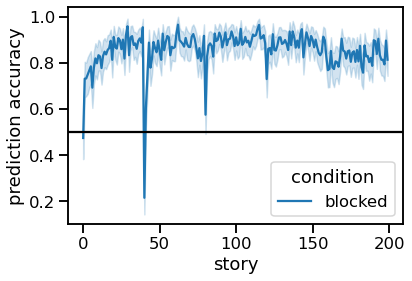

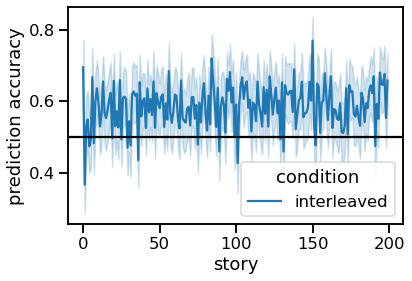

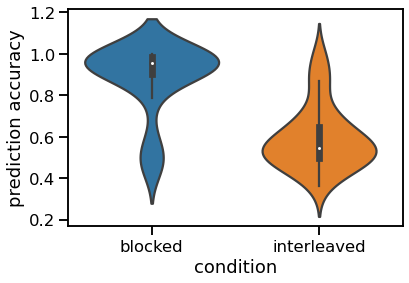

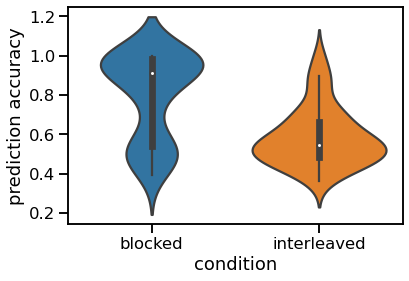

In [6]:
lineplt(['blocked','interleaved'],0.9)
beetestplt(['blocked','interleaved'],0.9)
beetestplt(['blocked','interleaved'],0.0)

### BIrep
- ross 5: human blocked-replication performance (should match lower-left part of Fig. 3 in Andre paper)
- ross 6: human interleaved-replication performance (should match lower-right part of Fig. 3 in Andre paper)
- ross 7: beeswarm plot of blocked-replication and interleaved-replication test accuracy (each dot is a participant; separate “beeswarms” for each condition)
- ross 8: beeswarm plot of blocked-replication and interleaved-replication test accuracy, including all participants (not just the “90% filtered” participants)

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

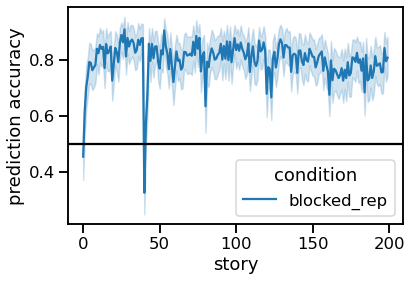

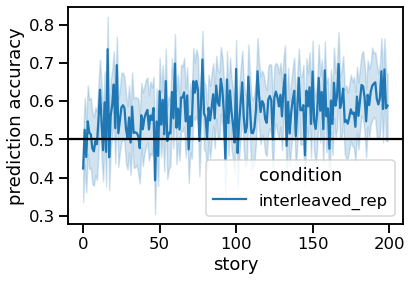

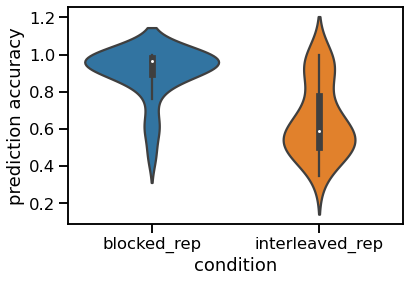

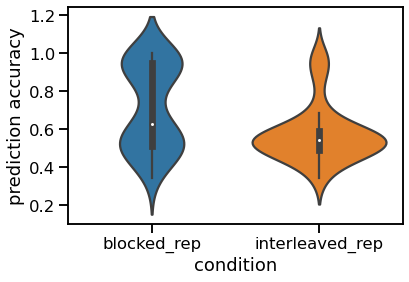

In [7]:
lineplt(['blocked_rep','interleaved_rep'],0.9)
beetestplt(['blocked_rep','interleaved_rep'],0.9)
beetestplt(['blocked_rep','interleaved_rep'],0.0)

### explicit
- ross 26: human interleaved-explicit performance (should match Fig. 4 in Andre paper)

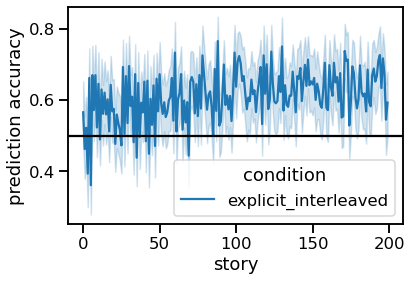

In [8]:
lineplt(['explicit_interleaved'],0.9)

## plot transition 2 and 3
- ross 37: human blocked performance (should match upper-left part of Fig. 3 in Andre paper) transition 2 only
- ross 38: human interleaved performance (should match upper-right part of Fig. 3 in Andre paper) transition 2 only
- ross 39: human blocked-replication performance (should match lower-left part of Fig. 3 in Andre paper) transition 2 only
- ross 40: human interleaved-replication performance (should match lower-right part of Fig. 3 in Andre paper) transition 2 only
- ross 41: human interleaved-explicit performance (should match Fig. 4 in Andre paper) transition 2 only


- ross 48: human blocked performance (should match upper-left part of Fig. 3 in Andre paper) transition 3 only
- ross 49: human interleaved performance (should match upper-right part of Fig. 3 in Andre paper) transition 3 only
- ross 50: human blocked-replication performance (should match lower-left part of Fig. 3 in Andre paper) transition 3 only
- ross 51: human interleaved-replication performance (should match lower-right part of Fig. 3 in Andre paper) transition 3 only
- ross 52: human interleaved-explicit performance (should match Fig. 4 in Andre paper) transition 3 only


##### transition 2

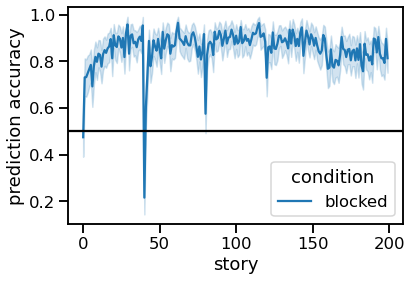

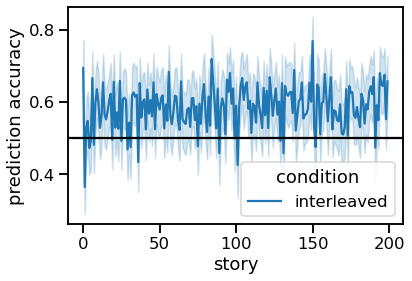

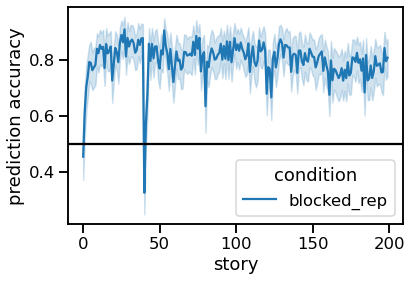

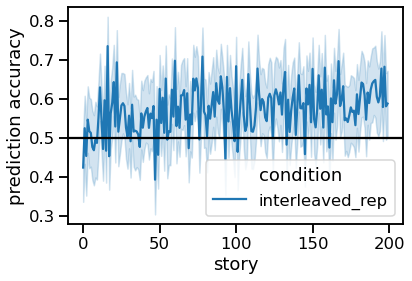

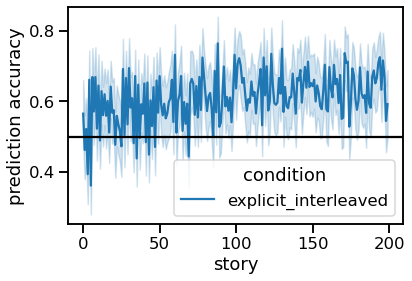

In [9]:
cL = ["blocked","interleaved","blocked_rep","interleaved_rep","explicit_interleaved"]
lineplt(cL,0.9,transition=1)


##### transition 3

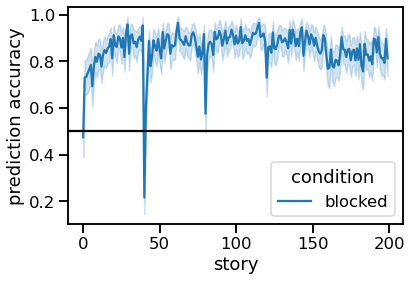

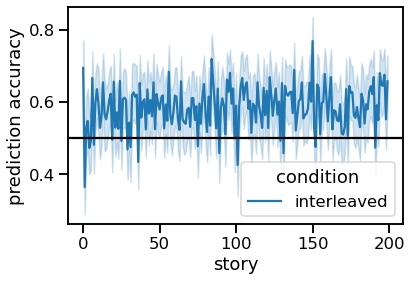

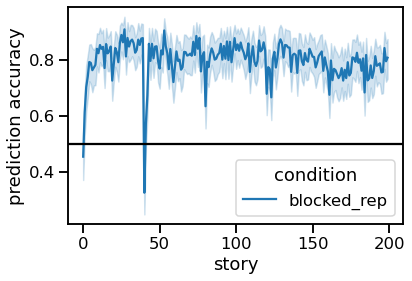

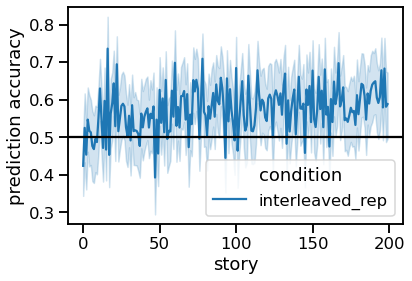

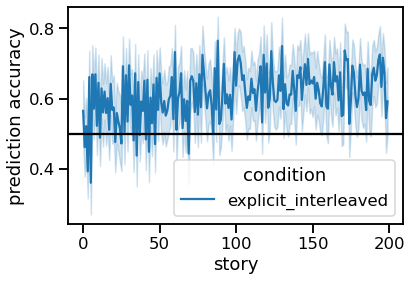

In [10]:
lineplt(cL,0.9,transition=2)

## plot model data

In [11]:
def lineplot_model(gsname,condstr):
  plt.figure()
  ax = plt.gca()
  ax.axhline(0.5,c='k')
  sns.lineplot(
    data=model_acc_df.query(f"gs=='{gsname}'&{condstr}"
                  ).groupby(['trial','cond']).mean().reset_index(),
    x='trial',y='acc',hue='cond',ax=ax
  )
  
def lineplot_modelBI(gsname):
  lineplot_model(gsname,condstr='cond<2')
  
def lineplot_modelEML(gsname):
  lineplot_model(gsname,condstr='cond>=2')
  

def beeswarm_model(gsname,condstr):
  plt.figure()
  ax = plt.gca()
  sns.swarmplot(
    data=model_acc_df.query(f"gs=='{gsname}'&test==True&{condstr}"
                  ).groupby(['seed','cond']).mean().reset_index(),
    x='cond',y='acc',ax=ax
  )
  
def beeswarm_modelBI(gsname):
  beeswarm_model(gsname,condstr='cond<2')
  
def beeswarm_modelEML(gsname):
  beeswarm_model(gsname,condstr='cond>=2')
  
    
def scatter_numlc_vs_acc(gsname):
  plt.figure()
  ax=plt.gca()
  cond = 1
  for six in range(100):
    q = f"gs=='{gsname}'&cond=={cond}&trial>=160&seed=={six}"
    seed_states_df = model_states_df.query(q)
    sacc = model_acc_df.query(q).acc.mean() 
    nlc = seed_states_df.zt.max()+1
    ax.scatter(nlc,sacc,c='k')

  ax.set_ylabel('seed test accuracy')
  ax.set_xlabel('seed num latent causes')
  
def scatter_adjrand_vs_acc(gsname):
  plt.figure()
  ax=plt.gca()
  for six in range(100):
    q = f"seed=={six} & gs=='{gsname}'& cond==1 & trial>=160"
    sdf_states = model_states_df.query(q)
    sacc = model_acc_df.query(q).acc.mean()
    adjrand = adjusted_rand_score(
      sdf_states.query('tstep==1').exp,
      sdf_states.query('tstep==2').xth
    )
    ax.scatter(adjrand,sacc,c='k')
  ax.set_xlabel('adjusted rand')
  ax.set_ylabel('acc')


# version 5: skipt1 = false; no variability across seeds 
- ross 9: model version 5 (skipt1=false, no var across seeds) blocked performance
- ross 10: model version 5 (skipt1=false, no var across seeds) interleaved performance 
- ross 11: model version 5 (skipt1=false, no var across seeds) beeswarm plot of blocked and interleaved test accuracy (each dot is a seed; separate “beeswarms” for each condition)


/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


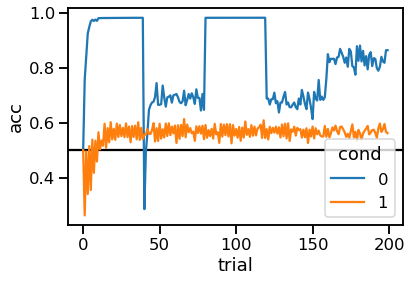

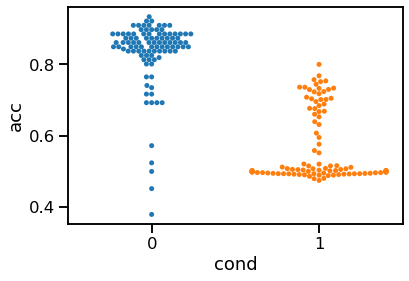

In [12]:
gsname = 'gs0317_version5_skipt1False'
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)

# version 1: skipt1 = true; no variability across seeds
- ross 12: blocked performance
- ross 13: interleaved performance 
- ross 14: beeswarm plot of blocked and interleaved test accuracy 
- ross 15: scatterplot of “new adjusted rand” vs. test accuracy in the interleaved condition (each dot is a seed) (“new adjusted rand” tracks whether the model tends to respond with the same 5 vs. 6 state depending on whether the actual state is 1 vs. 2)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 53.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


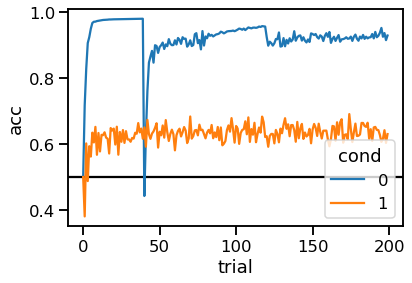

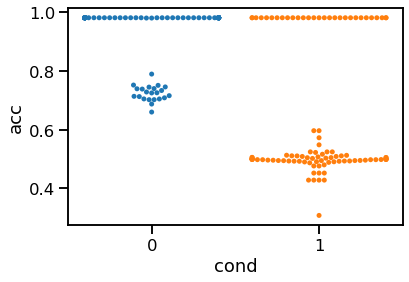

In [13]:
gsname = 'gs0317'
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)

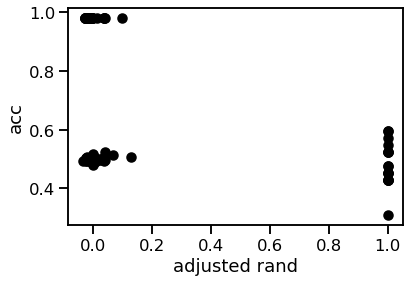

In [14]:
scatter_adjrand_vs_acc(V1)

### human adjusted rand vs testacc
- ross 16: human interleaved data scatterplot of “new adjusted rand” vs. test accuracy (each dot is a participant)

Text(0.5, 1.0, 'humans interleaved')

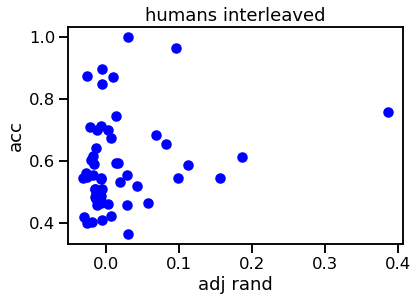

In [15]:
ax=plt.gca()
for six,sdf in human_df.query("condition=='interleaved' & story>=160").groupby('subjnum'):
  acc = sdf.correct_response.mean()
  sdf_ = sdf.query("depth==1")
  adjrand = adjusted_rand_score(sdf_.response_node_int,sdf_.rfc_int)
  ax.scatter(adjrand,acc,c='b')
ax.set_xlabel('adj rand')
ax.set_ylabel('acc')
ax.set_title('humans interleaved')

#### TODO: scatter yoked sequence seed acc to human acc. see ross version 8 (plots 59,60)
- there may also be a benefit to making a scatterplot of actual accuracy vs. predicted accuracy in the interleaved (and interleaved replication) condition for “sequence matched” model seeds and participants – we expect that the r value for this scatterplot should be close to zero; note that ross did this for gridsearch version 8 (see ross plots 59, 60) – you should be able to leverage this code to re-do the analysis for gridsearch version 1

 no rep pid_acc_list:  39
rep pid_acc_list:  24


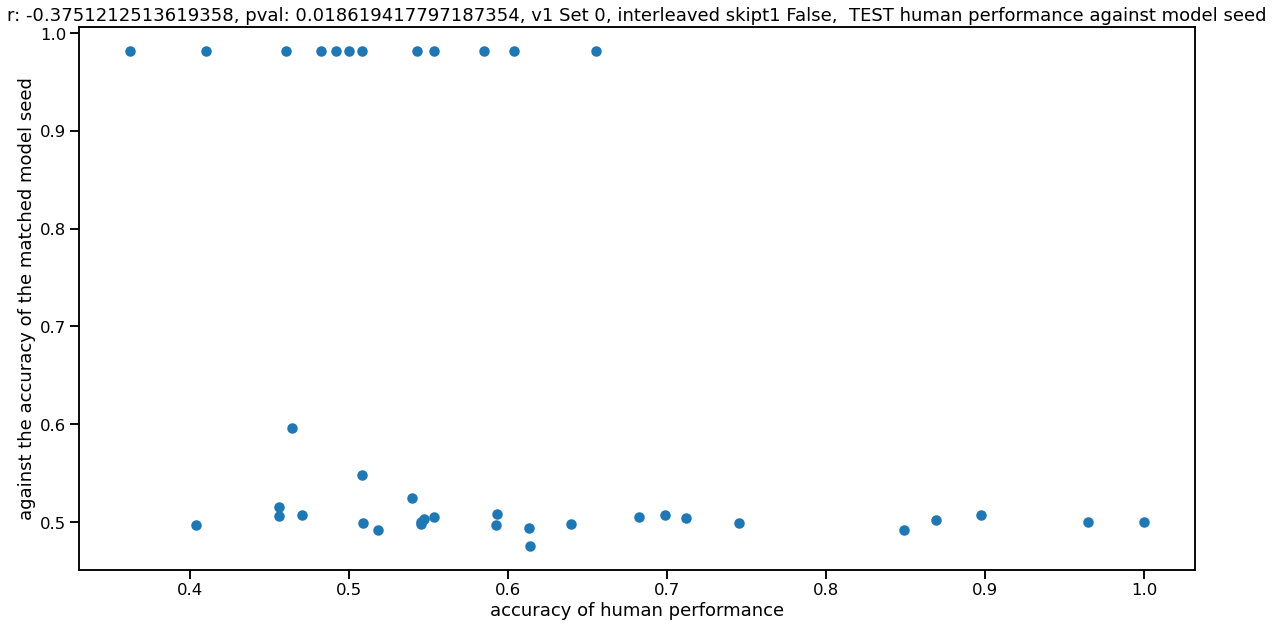

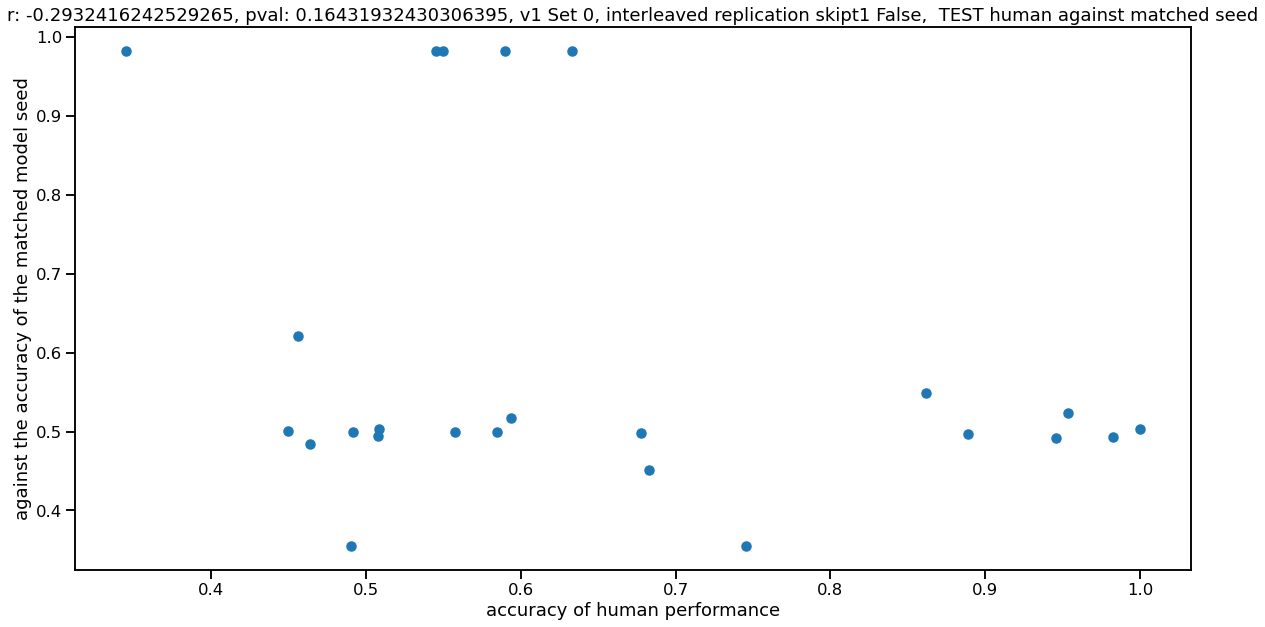

In [16]:
# get the scatter plots 
gsname = 'gs0317'
# gsdf = pd.read_csv('/Volumes/norman/rkempner/interleaved_blocked_modeling/data/gs0317_version8_skipt1False_except_blocked/%s-summdf.csv'%gsname).astype(float) # for each grid we have the mse for the various conditions
gsdf = pd.read_csv('~/wd/csw/interleaved_blocked_modeling/data/all_csv/%s-summdf.csv'%gsname).astype(float) # for each grid we have the mse for the various conditions
gsdf.loc[:,"mse-bi"] = gsdf.b_mse1+gsdf.b_mse2+gsdf.i_mse1+gsdf.i_mse2
TOP_K = 1
## select top40 MSE
topKgsdf = gsdf.sort_values('mse-bi').iloc[:TOP_K]
## LOOP
for rank,(idx,row) in enumerate(topKgsdf.iterrows()):
  param_set_num = rank
  args,paramstr = get_argsD(row)

  # interleaved
  participant_to_exp_path = "versionX_interleaved_participant_to_exp.pickle"
  participant_to_measures = run_exps_feedHumanExp_v7(participant_to_exp_path, args)
  raw_acc = unpack_acc_feedHuman_v7(participant_to_measures,mean_over_tsteps=False) # curr,seeds,tsteps,trials

  each_matched_seed_acc = raw_acc[:,:,160:].mean((1,2)).tolist()
  participant_to_testAcc_path = "versionX_interleaved_participant_to_testAcc.pickle"
  with open(participant_to_testAcc_path, 'rb') as pickle_file:
    participant_to_testAcc = pickle.load(pickle_file)
  pid_acc_list = []
  matched_seed_acc_list = []
  for pid in sorted(list(participant_to_testAcc.keys())):
    matched_seed_acc_list.append(each_matched_seed_acc[pid])
    pid_acc_list.append(participant_to_testAcc[pid])
  print(" no rep pid_acc_list: ", len(pid_acc_list))
#   plt.clf()
  plt.figure(figsize=(20,10))
  plt.scatter(pid_acc_list,matched_seed_acc_list)
  plt.xlabel("accuracy of human performance")
  plt.ylabel("against the accuracy of the matched model seed")
  r, pval = scipy.stats.pearsonr(pid_acc_list,matched_seed_acc_list)
  plt.title("r: " + str(r) + ", pval: " + str(pval) + ", v1 Set " + str(param_set_num) + ", interleaved skipt1 False,  TEST human performance against model seed")
#   plt.show()

  # interleaved rep
  participant_to_exp_path = "versionX_interleavedRep_participant_to_exp.pickle"
  participant_to_measures = run_exps_feedHumanExp_v7(participant_to_exp_path, args)
  raw_acc = unpack_acc_feedHuman_v7(participant_to_measures,mean_over_tsteps=False) # curr,seeds,tsteps,trials
  #pdb.set_trace()
  each_matched_seed_acc = raw_acc[:,:,160:].mean((1,2)).tolist()
  participant_to_testAcc_path = "versionX_interleavedRep_participant_to_testAcc.pickle"
  with open(participant_to_testAcc_path, 'rb') as pickle_file:
    participant_to_testAcc = pickle.load(pickle_file)
  pid_acc_list = []
  matched_seed_acc_list = []
  for pid in sorted(list(participant_to_testAcc.keys())):
    matched_seed_acc_list.append(each_matched_seed_acc[pid])
    pid_acc_list.append(participant_to_testAcc[pid])
  print("rep pid_acc_list: ", len(pid_acc_list))
#   plt.clf()
  plt.figure(figsize=(20,10))
  plt.scatter(pid_acc_list,matched_seed_acc_list)
  plt.xlabel("accuracy of human performance")
  plt.ylabel("against the accuracy of the matched model seed")
  r, pval = scipy.stats.pearsonr(pid_acc_list,matched_seed_acc_list)
  plt.title("r: " + str(r) + ", pval: " + str(pval) + ", v1 Set " + str(param_set_num) + ", interleaved replication skipt1 False,  TEST human against matched seed")
#   plt.show()
  




# version 2: skipt1 = true; variable concentration across seeds 
- ross 17: blocked performance
- ross 18: interleaved performance
- ross 19: beeswarm plot of blocked and interleaved test accuracy 
- ross 20: scatterplot of test accuracy vs. #-of-latent-causes (each dot is a seed) for the interleaved condition
- ross 21: scatterplot of concentration vs. #-of-latent-causes (each dot is a seed) for the interleaved condition


/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 55.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


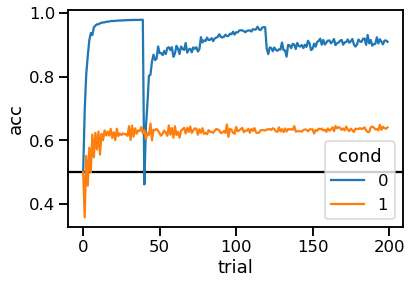

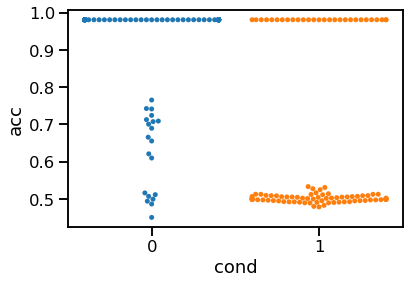

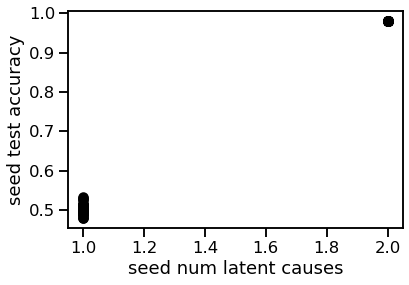

In [17]:
gsname="gs0317_concentrationAcross"
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)
scatter_numlc_vs_acc(gsname)

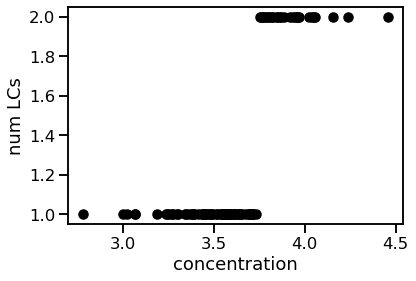

In [18]:
def scatter_concentration_vs_numlc(gsname):
  ax=plt.gca()
  for six,sdf in model_states_df.query(f"gs=='{gsname}'&cond==1").groupby('seed'):
    numlc=sdf.zt.max()
    ax.scatter(sdf.alpha.unique(),numlc+1,c='k')
  ax.set_xlabel('concentration')
  ax.set_ylabel('num LCs')
scatter_concentration_vs_numlc(V2)

# version 9: skipt1 = true starting in 2nd block for blocked, always false for interleaved; variable concentration across seeds
ross 64: model version 9, parameter set 0, blocked performance

ross 65: model version 9, parameter set 0, interleaved performance

ross 66: model version 9, parameter set 0, beeswarm plot of blocked and interleaved test accuracy (each dot is a seed; separate “beeswarms” for each condition)

ross 67: model version 9, parameter set 0, scatterplot of test accuracy vs. #-of-latent-causes (each dot is a seed) for the interleaved condition (same as plot 20 except for model version 9)

ross 68: model version 9, parameter set 0, scatterplot of concentration vs. #-of-latent-causes (each dot is a seed) for the interleaved condition (same as plot 21 except for model version 9)


/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 62.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


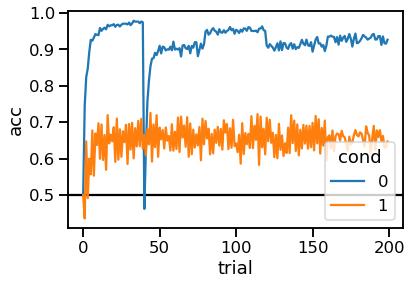

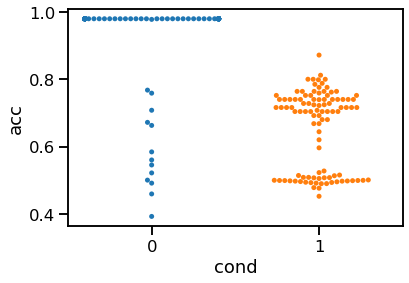

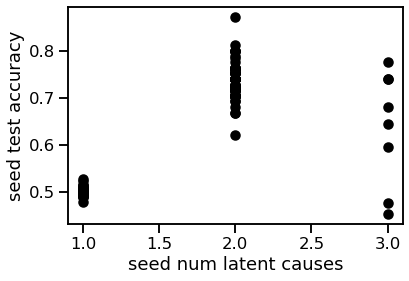

In [19]:
gsname="gs0317_version9_concentrationAcross_skipt1False_except_blocked"
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)
scatter_numlc_vs_acc(gsname)

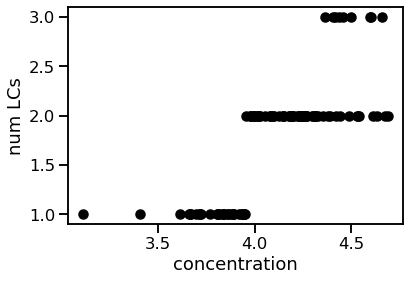

In [20]:
# takes longer to run than above
scatter_concentration_vs_numlc(gsname)

## version 9: EML predictions
- ross 69: model version 9, parameter set 0, early performance (same as plot 22 except for model version 9)
- ross 70: model version 9, parameter set 0, middle performance (same as plot 23 except for model version 9)
- ross 71: model version 9, parameter set 0, late performance (same as plot 24 except for model version 9)
- ross 72: model version 9, parameter set 0, beeswarm plot of early, middle, late test accuracy (each dot is a seed; separate “beeswarms” for each condition) (same as plot 25 except for model version 9)


/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 45.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


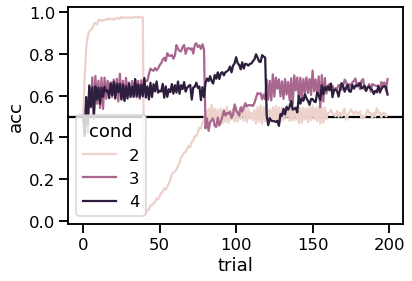

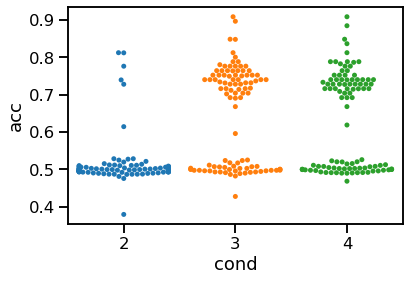

In [21]:
gsname="gs0317_version9_concentrationAcross_skipt1False_except_blocked"
lineplot_modelEML(gsname)
beeswarm_modelEML(gsname)

# human EML
ross 27: human early performance (should match top-left part of Fig. 8 in Andre paper)

ross 28: human middle performance (should match middle-left part of Fig. 8 in Andre paper)

ross 29: human late performance (should match bottom-left part of Fig. 8 in Andre paper)

ross 30: beeswarm plot of human early, middle, late test accuracy (each dot is a participant; separate “beeswarms” for each condition)

ross 31: beeswarm plot of human early, middle, late test accuracy including all participants (not just the “90% filtered” participants)

ross 32: human early-replication performance (should match top-right part of Fig. 8 in Andre paper)

ross 33: human middle-replication performance (should match middle-right part of Fig. 8 in Andre paper)

ross 34: human late-replication performance (should match bottom-right part of Fig. 8 in Andre paper)

ross 35: beeswarm plot of early-replication, middle-replication, late-replication test accuracy (each dot is a participant; separate “beeswarms” for each condition)

ross 36: beeswarm plot of early-replication, middle-replication, late-replication test accuracy including all participants (not just the “90% filtered” participants)


In [22]:
human_df.condition.unique()

array(['blocked', 'interleaved', 'blocked_rep', 'interleaved_rep',
       'explicit_interleaved', 'inserted_early', 'inserted_middle',
       'inserted_late', 'inserted_early_rep', 'inserted_middle_rep',
       'inserted_late_rep'], dtype=object)

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

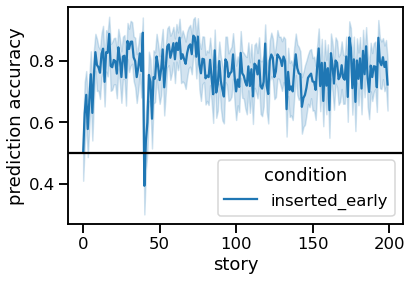

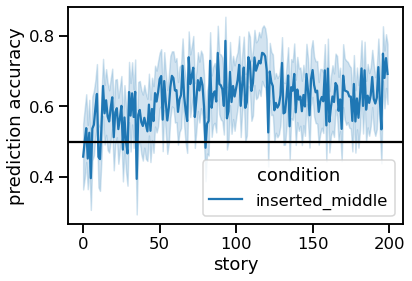

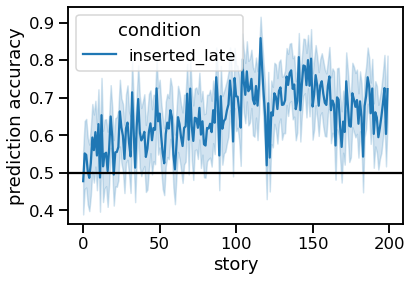

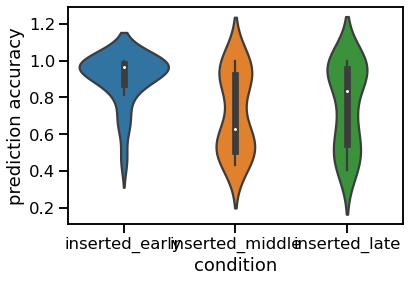

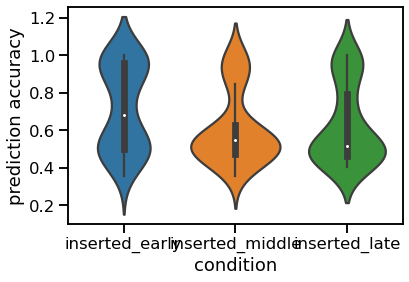

In [23]:
condL = ['inserted_early','inserted_middle','inserted_late']
lineplt(condL,0.9)
beetestplt(condL,0.9)
beetestplt(condL,0.0)

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

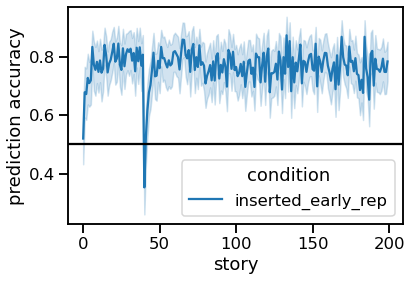

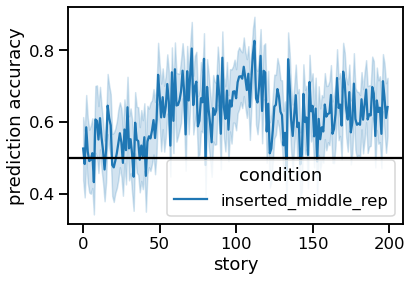

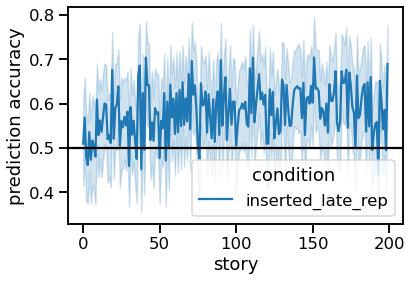

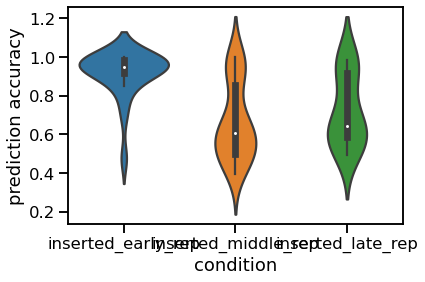

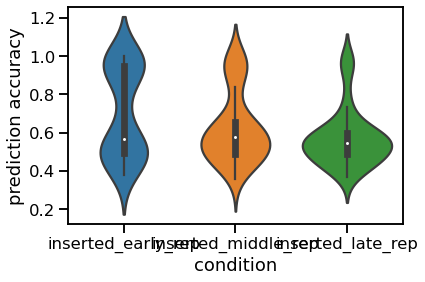

In [24]:
condL = ['inserted_early_rep','inserted_middle_rep','inserted_late_rep']
lineplt(condL,0.9)
beetestplt(condL,0.9)
beetestplt(condL,0.0)

- ross 42: human early performance (should match top-left part of Fig. 8 in Andre paper) transition 2 only
- ross 43: human middle performance (should match middle-left part of Fig. 8 in Andre paper) transition 2 only
- ross 44: human late performance (should match bottom-left part of Fig. 8 in Andre paper) transition 2 only
- ross 45: human early-replication performance (should match top-right part of Fig. 8 in Andre paper) transition 2 only
- ross 46: human middle-replication performance (should match middle-right part of Fig. 8 in Andre paper) transition 2 only
- ross 47: human late-replication performance (should match bottom-right part of Fig. 8 in Andre paper) transition 2 only
- ross 53: human early performmance (should match top-left part of Fig. 8 in Andre paper) transition 3 only
- ross 54: human middle performance (should match middle-left part of Fig. 8 in Andre paper) transition 3 only
- ross 55: human late performance (should match bottom-left part of Fig. 8 in Andre paper) transition 3 only
- ross 56: human early-replication performance (should match top-right part of Fig. 8 in Andre paper) transition 3 only
- ross 57: human middle-replication performance (should match middle-right part of Fig. 8 in Andre paper) transition 3 only
- ross 58: human late-replication performance (should match bottom-right part of Fig. 8 in Andre paper) transition 3 only


##### transition 2

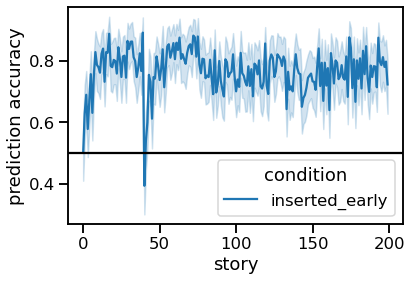

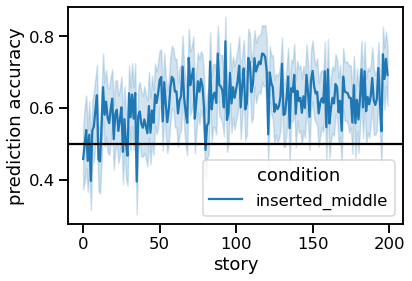

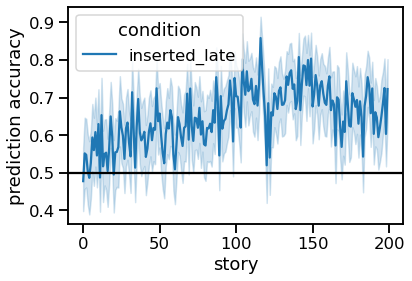

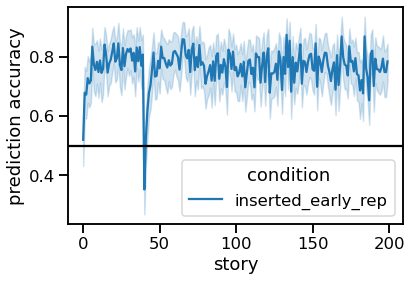

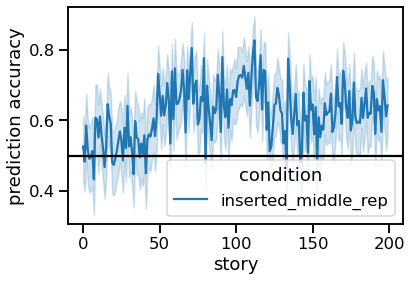

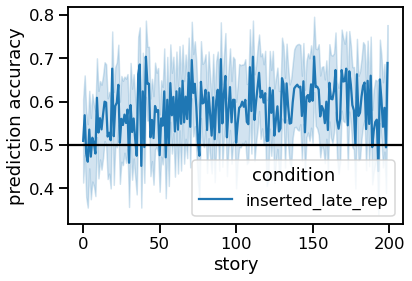

In [25]:
cL = [
  'inserted_early','inserted_middle','inserted_late',
  'inserted_early_rep','inserted_middle_rep','inserted_late_rep'
]
# for c in cL:
#   ax=plt.gca()
lineplt(cL,0.9,transition=1,ax=ax)

  

###### transition 3

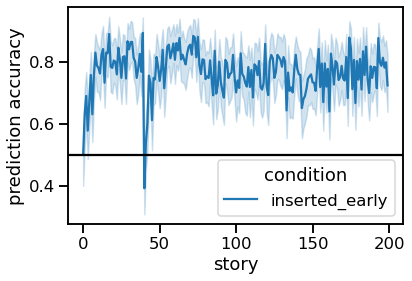

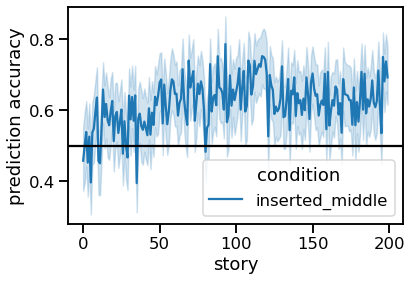

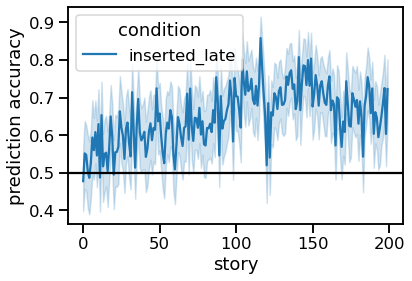

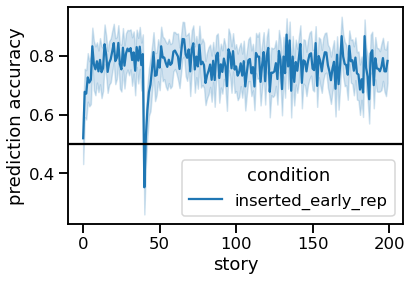

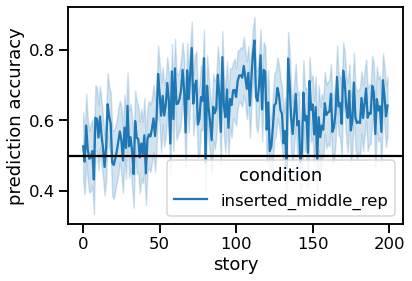

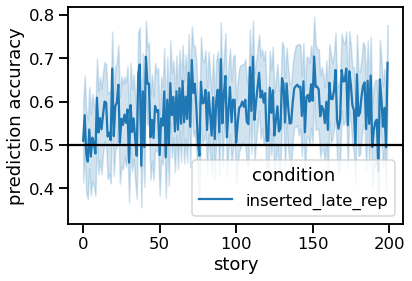

In [26]:
lineplt(cL,0.9,transition=2,ax=ax)